# Imports

In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
import netCDF4 as nc

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from icedef import iceberg, metocean, drift_simulation, plot, tools
from icedef.turnbull import drift

# Iceberg

In [2]:
df = pd.read_csv('ftp://data.munroelab.ca/pub/iceberg/beacon/0204980_2015.csv')

df['DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])

times = [t.to_pydatetime() for t in df['DataDate_UTC']]

max_hr = 24
dt_vec = np.asarray([(time - times[0]).days*24 + (time - times[0]).seconds/3600 for time in times])
max_hr_indx = np.where(dt_vec < max_hr)[0][-1]

df = df[:max_hr_indx+1]

times = [t.to_pydatetime() for t in df['DataDate_UTC']]
lons = df['Longitude']
lats = df['Latitude']

n = 100

lonn = lons[n]; lon0 = lons[0] 
latn = lats[n]; lat0 = lats[0]

dx, dy = tools.deg2m(lon0, lonn, lat0, latn) 
dist = np.sqrt(dx**2 + dy**2)

tn = times[n]; t0 = times[0]
dt = (tn - t0).days*3600 + (tn - t0).seconds

vx = dx/dt; vy = dy/dt


ref_berg = iceberg.Iceberg('0204980_2015', times[0], lons[0], lats[0], vx, vy, 0, 0, 'LG', 'TAB')

ref_berg.history['T'] = times; ref_berg.history['X'] = lons; ref_berg.history['Y'] = lats

berg = iceberg.clone_iceberg_state(ref_berg)

# Metocean

In [3]:
ocean_data = metocean.ECMWFOcean(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#ocean_data.filenames

atm_data = metocean.NARRAtm(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#atm_data.filenames

# Drift Simulation

### Timesteps

In [4]:
dt = 0.1*3600
t0 = ref_berg.history['T'][0]
tf = ref_berg.history['T'][-1]
tdelta = tf - t0
tdelta_secs = tdelta.days*24*3600 + tdelta.seconds
nt = int(tdelta_secs//dt)

### Simulation

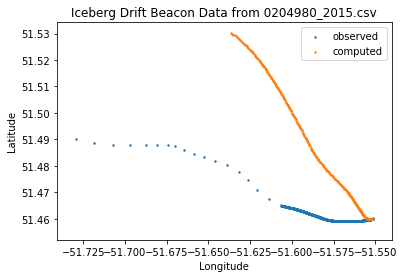

In [5]:
berg = iceberg.clone_iceberg_state(ref_berg)

sim = drift_simulation.DriftSimulation(berg, ocean_data, atm_data, drift)

#sim.euler(dt,nt)
sim.rk2(dt, nt)

# Plot

plt.scatter(ref_berg.history['X'], ref_berg.history['Y'], s=2, label='observed')
plt.scatter(sim.history['x'], sim.history['y'], s=2, label='computed')
plt.title('Iceberg Drift Beacon Data from 0204980_2015.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

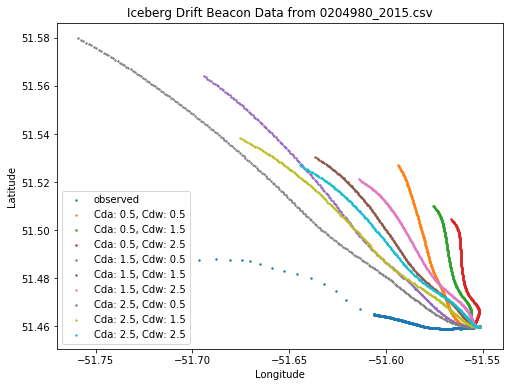

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(ref_berg.history['X'], ref_berg.history['Y'], s=2, label='observed')
plt.title('Iceberg Drift Beacon Data from 0204980_2015.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

drag_vec = [0.5, 1.5, 2.5]

for Cda in drag_vec:
    for Cdw in drag_vec:
    
        berg = iceberg.clone_iceberg_state(ref_berg)
        berg.Cda = Cda
        berg.Cdw = Cdw
        sim = drift_simulation.DriftSimulation(berg, ocean_data, atm_data, drift)
        sim.rk2(dt, nt)
        plt.scatter(sim.history['x'], sim.history['y'], s=2, label=f'Cda: {Cda}, Cdw: {Cdw}')

plt.legend()
plt.show()

In [31]:
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.interpolate import interp1d

In [14]:
ref_berg_times = nc.date2num(ref_berg.history['T'], ocean_data.T_UNITS, 
                             ocean_data.T_CALENDAR)
sim_berg_times = nc.date2num(sim.history['t'], ocean_data.T_UNITS, 
                             ocean_data.T_CALENDAR)

In [52]:
sim.history['t'][0]

datetime.datetime(2015, 4, 24, 15, 16, 6)

In [64]:
def calc_mse(sim_x, sim_y, sim_t, sim_t0, ref_xvec, ref_yvec, ref_tvec):
    t0_str = sim_t0.strftime("%Y-%m-%d %H:%M:%S")
    sim_t = nc.date2num(sim_t, f'hours since {t0_str}', 'standard')
    ref_tvec = nc.date2num(ref_tvec, f'hours since {t0_str}', 'standard')
    ref_x_interp1d = interp1d(ref_tvec, ref_xvec)
    ref_y_interp1d = interp1d(ref_tvec, ref_yvec)
    ref_x = ref_x_interp1d(sim_t); ref_y = ref_y_interp1d(sim_t)
    mse = np.sqrt((ref_x - sim_x)**2 + (ref_y - sim_y)**2)
    return mse

In [66]:
i = 100
sim_t0 = sim.history['t'][0]
sim_x = sim.history['x'][i]; sim_y = sim.history['y'][i]; sim_t = sim.history['t'][i]
ref_xvec = ref_berg.history['X']; ref_yvec = ref_berg.history['Y']; ref_tvec = ref_berg.history['T']; 
calc_mse(sim_x, sim_y, sim_t, sim_t0, ref_xvec, ref_yvec, ref_tvec)

0.04565242782770835

In [77]:
def drift_wrapper(Cda, sim, ref_berg, dt, nt):
    
    sim.berg.Cda = Cda
    #sim.berg.Cdw = Cdw
    
    sim.rk2(dt, nt)
    
    sim_t0 = sim.history['t'][0]
    sim_x = sim.history['x'][nt]; sim_y = sim.history['y'][nt]; sim_t = sim.history['t'][nt]
    ref_xvec = ref_berg.history['X']; ref_yvec = ref_berg.history['Y']; ref_tvec = ref_berg.history['T']; 
    mse = calc_mse(sim_x, sim_y, sim_t, sim_t0, ref_xvec, ref_yvec, ref_tvec)
    
    return mse

In [76]:
drift_wrapper(1, 1, sim, ref_berg, dt, nt)

0.11120309766239095

In [78]:
minimize(drift_wrapper, x0=1, args=(sim, ref_berg, dt, nt))

      fun: 0.06402671838120162
 hess_inv: array([[45.00484461]])
      jac: array([-2.75857747e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([2.83556173])

In [79]:
drift_wrapper(2.83556173, sim, ref_berg, dt, nt)

0.06402671838118873

# Animation

### Wind

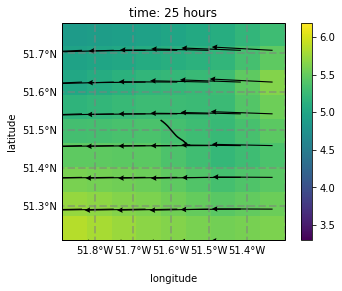

In [6]:
dx_scale = 3
dy_scale = 3
dt_scale = 3
grid_scales = [dx_scale, dy_scale, dt_scale]

x_berg = sim.history['x']
y_berg = sim.history['y']
t_berg = nc.date2num(sim.history['t'], atm_data.T_UNITS, atm_data.T_CALENDAR)
xyt_berg = [x_berg, y_berg, t_berg]

x_grid = atm_data.lons
y_grid = atm_data.lats
t_grid = atm_data.times
xyt_grid = [x_grid, y_grid, t_grid]

u_data = atm_data.U
v_data = atm_data.V
uv_data = [u_data, v_data]

plot.berg_metocean_animation(xyt_berg, xyt_grid, grid_scales, uv_data, 
                             fname='wind_anim', v_auto=True, scale=20, speed=500)

### Current

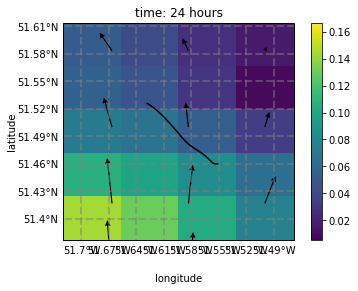

In [7]:
dx_scale = 1
dy_scale = 1
dt_scale = 1
grid_scales = [dx_scale, dy_scale, dt_scale]

x_berg = sim.history['x']
y_berg = sim.history['y']
t_berg = nc.date2num(sim.history['t'], ocean_data.T_UNITS, ocean_data.T_CALENDAR)
xyt_berg = [x_berg, y_berg, t_berg]

x_grid = ocean_data.lons
y_grid = ocean_data.lats
t_grid = ocean_data.times
xyt_grid = [x_grid, y_grid, t_grid]

u_data = ocean_data.U
v_data = ocean_data.V
uv_data = [u_data, v_data]

plot.berg_metocean_animation(xyt_berg, xyt_grid, grid_scales, uv_data, 
                             fname='current_anim', v_auto=True, scale=0.5, speed=500)

In [12]:
np.where(x_grid > -51.8)[0][0]

159

In [11]:
np.where(x_grid < -51.4)[0][-1]

163

In [13]:
np.where(y_grid > 51.4)[0][0]

137

In [14]:
np.where(y_grid < 51.7)[0][-1]

140

In [15]:
np.mean(u_data[:, 159:163+1, 137:140+1])

-0.1919608

In [16]:
np.mean(v_data[:, 159:163+1, 137:140+1])

-0.10271322

In [18]:
u2 = np.swapaxes(u_data, 1, 2)

In [19]:
np.mean(u2[:, 137:140+1,  159:163+1])

-0.1919608